In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
import IPython.display as ipd
import time
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.__version__

'2.2.0'

In [3]:
BATCH_SIZE = 32
EPOCHS = 30
NB_CLASS = 10

In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = np.expand_dims(np.array(X_train, dtype=np.float32), axis=-1)
X_test = np.expand_dims(np.array(X_test, dtype=np.float32), axis=-1)

X_train /= 255.
X_test /= 255.

np.random.seed(0)
idx = np.random.randint(0, len(X_train), size=30000)
X_train = X_train[idx]
y_train = y_train[idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30000, 28, 28, 1) (30000,)
(10000, 28, 28, 1) (10000,)


In [5]:
traindataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(BATCH_SIZE)
testdataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

In [6]:
from tensorflow.keras import models, layers, optimizers, losses, metrics

In [7]:
class Classifier(models.Model):
    def __init__(self):
        super(Classifier, self).__init__()
        self.c1 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.c2 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.c3 = layers.Conv2D(256, (3,3), activation=tf.nn.relu)
        self.flatten = layers.Flatten()
        self.latent = layers.Dense(4, activation=tf.nn.tanh)
        self.dense = layers.Dense(10, activation=tf.nn.softmax)
        
    def call(self, inputs, training=False):
        x = self.c1(inputs)
        x = self.c2(x)
        x = self.c3(x)
        x = self.flatten(x)
        x = self.latent(x)
        x = self.dense(x)
        return x
    
classifier = Classifier()

In [8]:
loss_obj = losses.SparseCategoricalCrossentropy()
acc_obj = metrics.SparseCategoricalAccuracy()
opt = optimizers.RMSprop(1e-4)

loss = metrics.Mean()
acc = metrics.Mean()

In [9]:
l2_distance = losses.MeanSquaredError()

In [10]:
def large_margin(xk, _y):
    _BATCH_SIZE = len(xk)
    
    # 정답 인덱싱 위한 것
    yk = np.array(list(zip(np.arange(_BATCH_SIZE), _y)))
    
    # minimum distance gamma
    _gamma = .5

    # f_i (x_k)
    _fi = list()

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xk)
        fi = classifier(xk)

        for i in range(NB_CLASS):
            _fi.append(fi[:,i])
        # f_{y_k} (x_k),  정답 인덱싱으로부터 정답 소프트맥스 값만으로 된 f_yk (xk) 만듦
        fyk = tf.gather_nd(fi, yk)
        fyk = tf.transpose(tf.cast([fyk for _ in range(NB_CLASS)], dtype=tf.float32))
        
    # 분자
    numerator = fi - fyk

    # 분모
    Dfi = list()
    for i in range(NB_CLASS):
        # 기계적으로 계산하기 위해, 분자 0 안되도록 작은 수 더함
        Dfi.append(tape.gradient(_fi[i], xk)+1e-15)
    Dfi = tf.cast(Dfi, dtype=tf.float32)
    Dfyk = tape.gradient(fyk, xk)

    _loss = 0
    for j in range(_BATCH_SIZE):
        for i in range(NB_CLASS):
            _loss += (_gamma + tf.math.maximum(0, (numerator[j,i]) / l2_distance(Dfi[i,j], Dfyk[j]))) 
            
    return _loss

def train_step(inputs):
    xk, _y = inputs
    
    with tf.GradientTape() as tape:
        pred = classifier(xk)
        _loss = large_margin(xk, _y)
        
    grads = tape.gradient(_loss, classifier.trainable_variables)
    opt.apply_gradients(list(zip(grads, classifier.trainable_variables)))
    
    loss.update_state(_loss)
    acc.update_state(acc_obj(_y, pred))

In [11]:
def test_step(inputs):
    _X, _y = inputs
    
    pred = classifier(_X)
    _loss = loss_obj(_y, pred)
        
    loss.update_state(_loss)
    acc.update_state(acc_obj(_y, pred))

In [ ]:
start_time = time.time()
for e in range(EPOCHS):
    epoch_time = time.time()
    for i, x in enumerate(traindataset):
        batch_time = time.time()
        train_step(x)
        ipd.clear_output(wait=True)
        print(f"{(i+1)}/{len(X_train)//BATCH_SIZE+1}, {e+1}/{EPOCHS}, loss={loss.result():.8f}, acc={100*acc.result():.2f}%, {time.time()-batch_time:.2f}secs/batch, {time.time()-epoch_time:.2f}secs/epoch, {time.time()-start_time:.2f}secs")
    loss.reset_states()
    acc.reset_states()

200/938, 1/30, loss=60530.82812500, acc=51.65%, 1.01secs/batch, 206.17secs/epoch, 206.17secs


In [20]:
for x in testdataset:
    test_step(x)
    
print(f"acc={100*acc.result():.2f}%")
loss.reset_states()
acc.reset_states()

acc=90.84%


In [21]:
def get_latent(x):
    for l in classifier.layers[:-1]:
        x = l(x)
    return x

In [22]:
latent = []

for s in range(0, len(X_test), BATCH_SIZE):
    e = min(len(X_test), s+BATCH_SIZE)
    _latent = get_latent(X_test[s:e])
    latent.extend(_latent)
    
latent = np.array(latent)
print(latent.shape)

(10000, 4)


In [23]:
from sklearn.decomposition import PCA

In [24]:
pca = PCA(n_components=2, random_state=0)

In [25]:
latent2d = pca.fit_transform(latent)

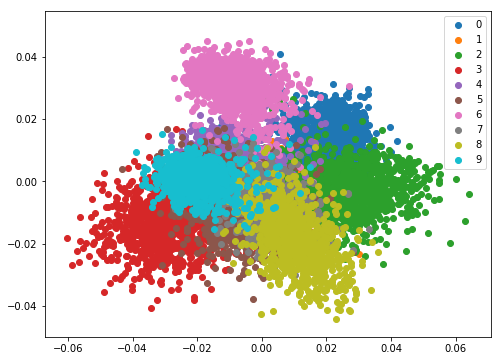

In [26]:
plt.figure(figsize=(8,6))
for i in range(10):
    idx = np.where(y_test==i)
    plt.scatter(latent2d[idx,0], latent2d[idx,1],label=str(i))
plt.legend()
plt.show()